# Uncertainty quantification with Conformal Prediction
> Tutorial on how to train neuralforecast models and obtain prediction intervals using the conformal prediction methods

Conformal prediction uses cross-validation on a model trained with a point loss function to generate prediction intervals. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

In this notebook, we demonstrate how to obtain prediction intervals using conformal prediction.

## Load libraries

In [1]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.utils import AirPassengersPanel
from neuralforecast.utils import PredictionIntervals
from neuralforecast.losses.pytorch import DistributionLoss, MAE, HuberIQLoss, HuberMQLoss, GMM, HuberLoss

/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-08 15:19:16,831	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-08 15:19:16,999	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

## Data

We use the AirPassengers dataset for the demonstration of conformal prediction.


In [3]:
horizon = 24

AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-horizon]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-horizon]].reset_index(drop=True)

## Model training

We now train a NHITS model on the above dataset. To support conformal predictions, we must first instantiate the `PredictionIntervals` class and pass this to the `fit` method. By default, `PredictionIntervals` class employs `n_windows=2` for the corss-validation during the computation of conformity scores. We also train a MLP model using DistributionLoss to demonstate the difference between conformal prediction and quantiled outputs. 

By default, `PredictionIntervals` class employs `method=conformal_distribution` for the conformal predictions, but it also supports `method=conformal_error`. The `conformal_distribution` method calculates forecast paths using the absolute errors and based on them calculates quantiles. The `conformal_error` method calculates quantiles directly from errors.

We consider two models below:

1. A model trained using a point loss function (`MAE`), where we quantify the uncertainty using conformal prediction. This case is labeled with `NHITS`.
2. A model trained using a `DistributionLoss('Normal')`, where we quantify the uncertainty by training the model to fit the parameters of a Normal distribution. This case is labeled with `NHITS1`.


In [ ]:
input_size = 24

prediction_intervals = PredictionIntervals()
max_steps=2
from pytorch_lightning.callbacks import EarlyStopping
level = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99]

models = [
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=HuberLoss(), scaler_type="minmax1", alias="conformal"), 
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=DistributionLoss("StudentT"), scaler_type="robust", alias="parametric", early_stop_patience_steps=2, val_check_steps=10),
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=GMM(weighted=True), scaler_type="robust", alias="mixture", early_stop_patience_steps=2, val_check_steps=10),
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=HuberMQLoss(level=level), scaler_type="robust", alias="MQLoss", early_stop_patience_steps=2, val_check_steps=10),          
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=HuberIQLoss(), scaler_type="robust", alias="IQLoss", early_stop_patience_steps=2, val_check_steps=10),
          NHITS(h=horizon, input_size=input_size, max_steps=max_steps, loss=DistributionLoss("ISQF", num_pieces=2, quantiles=[0.01, 0.1, 0.5, 0.9, 0.99]), scaler_type="minmax1", alias="ISQF", 
                early_stop_patience_steps=2, val_check_steps=10
                )
          ]          

nf = NeuralForecast(models=models, freq='ME')
nf.fit(AirPassengersPanel_train, val_size=horizon, prediction_intervals=prediction_intervals)

Seed set to 1
Seed set to 1
Seed set to 1
/home/osprangers/Repositories/neuralforecast/neuralforecast/common/_base_model.py:538: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              Model forward pass took 0.0038 seconds
Domain mapping took 0.0000 seconds
Loss computation took 0.0005 seconds
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=496, train_loss_step=0.473, train_loss_epoch=0.473]        Model forward pass took 0.0013 seconds
Domain mapping took 0.0000 seconds
Loss computation took 0.0004 seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.55it/s]


/home/osprangers/Repositories/neuralforecast/neuralforecast/common/_base_model.py:538: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              Model forward pass took 0.0026 seconds
Domain mapping took 0.0000 seconds
Loss computation took 0.0005 seconds
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=498, train_loss_step=0.306, train_loss_epoch=0.306]        Model forward pass took 0.0016 seconds
Domain mapping took 0.0000 seconds
Loss computation took 0.0004 seconds
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             Model forward pass took 0.0022 seconds
Domain mapping took 0.0003 seconds
Loss computation took 0.0190 seconds
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=499, train_loss_step=6.000, train_loss_epoch=6.000]        Model forward pass took 0.0016 seconds
Domain mapping took 0.0000 seconds
Loss computation took 0.0184 seconds
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, v_num=499, train_loss_step=5.650, train_loss_epoch=5.650, valid_loss=5.650]


/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'neuralforecast.losses.pytorch.BaseISQF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Model forward pass took 0.0045 seconds
Domain mapping took 0.1056 seconds
Loss computation took 0.1801 seconds
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=500, train_loss_step=6.320, train_loss_epoch=6.320]        Model forward pass took 0.0015 seconds
Domain mapping took 0.0206 seconds
Loss computation took 0.0367 seconds
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s, v_num=500, train_loss_step=6.130, train_loss_epoch=6.130, valid_loss=6.160]


## Forecasting

To generate conformal intervals, we specify the desired levels in the `predict` method. 

In [5]:
preds = nf.predict(futr_df=AirPassengersPanel_test, level=level)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.82it/s] 


/home/osprangers/Repositories/neuralforecast/.venv/lib/python3.10/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'neuralforecast.losses.pytorch.BaseISQF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


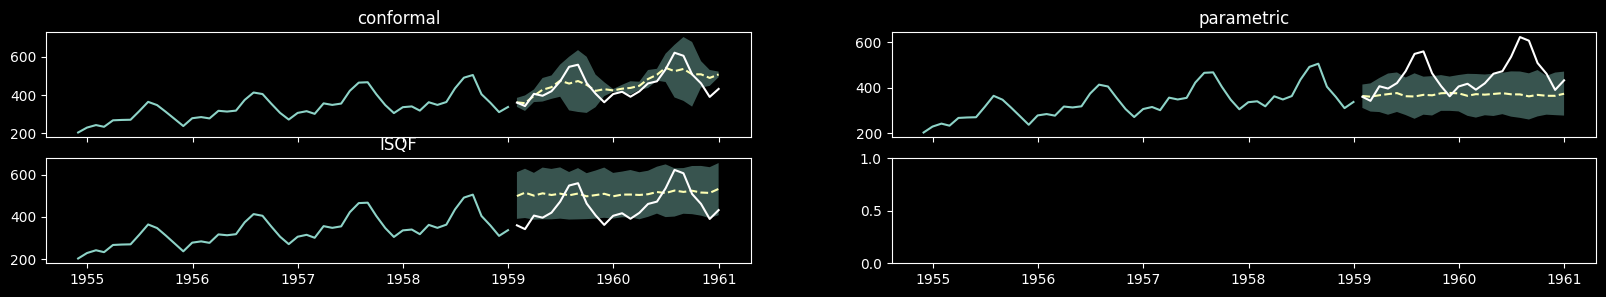

In [6]:
id_col = 'unique_id'
time_col = 'ds'
target_col = 'y'
unique_id = "Airline1"

n_plots = len(models)
plt.style.use('dark_background')
fig, axs = plt.subplots(n_plots // 2 + 1, 2, figsize=(2 * 10, 3 * (n_plots // 2)), sharex=True)
plot_df = preds
plot_df = preds.rename(columns={"MQLoss-median": "MQLoss", "IQLoss-median": "IQLoss"})

for i, model in enumerate(nf.models):
    ax = axs[i // 2][i % 2]
    ax.plot(AirPassengersPanel_train.query("unique_id == @unique_id")[time_col].iloc[-50:], AirPassengersPanel_train.query("unique_id == @unique_id")[target_col].iloc[-50:], label='y')
    ax.plot(plot_df.query("unique_id == @unique_id")[time_col], plot_df.query("unique_id == @unique_id")[f"{model}"], label=f'{model}', linestyle='--')
    ax.plot(AirPassengersPanel_test.query("unique_id == @unique_id")[time_col], AirPassengersPanel_test.query("unique_id == @unique_id")[target_col], label='y_test', color='white')
    ax.fill_between(x=plot_df.query("unique_id == @unique_id")[time_col][-horizon:], 
                 y1=plot_df.query("unique_id == @unique_id")[f"{model}-lo-90"][-horizon:].values,
                 y2=plot_df.query("unique_id == @unique_id")[f"{model}-hi-90"][-horizon:].values,
                 alpha=0.4, label='level 90')    
    
    ax.set_title(f"{model}")
    # ax.legend()

In [7]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, scaled_crps, coverage


# level = [90]
plot_df = preds.rename(columns={"MQLoss-median": "MQLoss", "IQLoss-median": "IQLoss"})

eval_df = plot_df.merge(AirPassengersPanel_test[[id_col, time_col, target_col]], on=[id_col, time_col], how='left')

metrics = evaluate(df=eval_df, 
                   metrics=[mse, 
                            mae, 
                            scaled_crps,
                            coverage
                            ], 
                   level=level[1:],
                models=[
                        "conformal", 
                        "parametric", 
                        # "mixture", 
                        # "MQLoss", 
                        # "IQLoss", 
                        "ISQF",
                        ],
                   agg_fn='mean')

metrics

,metric,conformal,parametric,ISQF
0,mse,2477.166978,12606.343028,8419.382625
1,mae,38.141190,86.310745,82.533065
2,scaled_crps,0.046943,0.097645,0.080001
3,coverage_level10,0.208333,0.000000,0.000000
4,coverage_level20,0.291667,0.041667,0.020833
5,coverage_level30,0.458333,0.125000,0.083333
6,coverage_level40,0.500000,0.145833,0.166667
7,coverage_level50,0.583333,0.250000,0.208333
8,coverage_level60,0.625000,0.312500,0.354167
9,coverage_level70,0.625000,0.416667,0.375000
